In [1]:
using Revise

In [2]:
using OpticalBlochEquations, QuantumStates

In [3]:
using HalfIntegers

In [4]:
using Plots
using BenchmarkTools
using DifferentialEquations

In [5]:
using Parameters, LinearAlgebra
import WignerSymbols: wigner3j, wigner6j

### Construct ${}^2 \Pi_{1/2}A(J' = 1/2, e)$ state (Hund's case (a))

In [6]:
# Spectroscopic constants for CaF, A state
BeA = 10456.2
AsoA = 2.1414e6
b00A = -4.8
p = -1334.6
q = -8.742
;

In [7]:
η = (S = 1//2, I = 1//2, Λ = 1, Σ = -1//2, Ω = 1//2, J = 1//2, F = 1, M = 0)
QN_bounds = (Ω = (-1//2, 1//2),)

HundsCaseA(; η...)
states1 = enumerate_states(η, HundsCaseA, QN_bounds)

η = (S = 1//2, I = 1//2, Λ = -1, Σ = 1//2, Ω = -1//2, J = 1//2, F = 1, M = 0)
QN_bounds = (Ω = (-1//2, 1//2),)

HundsCaseA(; η...)
states2 = enumerate_states(η, HundsCaseA, QN_bounds)

states = [states1; states2]
states = [state for state in states if state.J == 1//2]

n_states = length(states)
states = States(basis=states)
;

In [8]:
H0 = zeros(Float64, length(states.basis), length(states.basis))
for (i, state) in enumerate(states.basis)
    for (j, state′) in enumerate(states.basis)
        H0[i,j] += 
            BeA * Rotation(state, state′) + 
            AsoA * SpinOrbit(state, state′) + 
            b00A * (-Hyperfine_IL(state, state′) + Hyperfine_IF(state, state′))
    end
end;

In [9]:
function Λ_Doubling(state::HundsCaseA_Parity, state′::HundsCaseA_Parity)
    S, I, Λ, Σ, Ω, P, J, F, M = 
        state.S, state.I, state.Λ, state.Σ, state.Ω, state.P, state.J, state.F, state.M
    S′, I′, Λ′, Σ′, Ω′, P′, J′, F′, M′ = 
        state′.S, state′.I, state′.Λ, state′.Σ, state′.Ω, state′.P, state′.J, state′.F, state′.M
    
    if Ω == 1//2
        doubling = -P * (-1)^(J - S) * (J + 1/2) / 2
    else
        doubling = 0
    end
    
    return doubling * 
        δ(S, S′) * δ(I, I′) * δ(J, J′) * δ(F, F′) * δ(M, M′) * δ(Ω, Ω′) * δ(Σ, Σ′) * δ(Λ, Λ′) * δ(P, P′)
end;

In [10]:
η = (S = 1//2, I = 1//2, Λ = 1, Σ = 1//2, Ω = 1//2, P = 1, J = 1//2, F = 1, M = 0)
QN_bounds = (P = (-1, 1),)

HundsCaseA_Parity(; η...)
parity_states = enumerate_states(η, HundsCaseA_Parity, QN_bounds)
parity_states = [state for state in parity_states if state.J == 1//2 && state.P == 1]
;

In [11]:
# H_LD = zeros(Float64, length(parity_states.basis), length(parity_states.basis))
# for (i, state) in enumerate(parity_states.basis)
#     for (j, state′) in enumerate(parity_states.basis)
#         H_LD[i,j] += p * Λ_Doubling(state, state′)
#     end
# end
# H_LD = parity_states.states' * H_LD * parity_states.states

# H_A = H0 + H_LD
# ;

In [12]:
states_A = States(basis=parity_states)
states_A = convert_basis(states_A, states.basis, overlap)
;

### Construct the $N = 1$ state (Hund's case (b))

In [13]:
BeX = 10267.3963
γSRX = 39.498076
b00X = 108.475273
c00X = 40.6471
;

In [14]:
η = (S = 1//2, I = 1//2, Λ = 0, N = 1, J = 1//2, F = 1, M = 0)
QN_bounds = (N = (0,2),)

states_X = enumerate_states(η, HundsCaseB, QN_bounds)
states_X = States(basis=states_X)
;

In [15]:
H0 = zeros(Float64, length(states_X.basis), length(states_X.basis))
H_IK = deepcopy(H0)
H_SK = deepcopy(H0)
H_diag = BeX * Rotation + γSRX * SpinRotation + b00X * Hyperfine_IS
for (i, state) in enumerate(states_X.basis)
    for (j, state′) in enumerate(states_X.basis)
        H0[i,j] = H_diag(state, state′)
        H_IK[i,j] = Hyperfine_IK(state, state′)
        H_SK[i,j] = Hyperfine_SK(state, state′)
    end
end
H0 .+= c00X * H_IK * H_SK;

In [16]:
es, vs = eigen(H0)
states_X.states = vs
;

In [17]:
function TransitionDipoleMoment(state::HundsCaseA, state′::HundsCaseA, p::Integer)
    S, I, Λ, Σ, Ω, J, F, M = state.S, state.I, state.Λ, state.Σ, state.Ω, state.J, state.F, state.M
    S′, I′, Λ′, Σ′, Ω′, J′, F′, M′ = state′.S, state′.I, state′.Λ, state′.Σ, state′.Ω, state′.J, state′.F, state′.M
    
    return (-1)^(F′ - M′) * wigner3j(F′, 1, F, -M′, p, M) * (-1)^(F + J′ + I + 1) * sqrt((2F′ + 1) * (2F + 1)) *
        δ(Σ, Σ′) * (-1)^(J′ - Ω′) * wigner6j(J, F, I, F′, J′, 1) * sqrt((2J′ + 1) * (2J + 1)) *
        sum(
            wigner3j(J′, 1, J, -Ω′, q, Ω) for q in -1:1
        )
end;

In [18]:
import Base.==

function ==(state::State, state′::State)
    state_type = typeof(state)
    for field in fieldnames(state_type)
        if getfield(state, field) != getfield(state′, field)
            return false
        end
    end
    return true
end;

In [19]:
function caseb_to_casea(b_states)
    a_states = HundsCaseA[]
    for state in b_states.basis
        S, I, N, Λ, J, F, M = unpack(state)
        for Σ in -S:S
            Ω = Σ + Λ
            coeff = (-1)^(J - S + Λ) * sqrt(2N + 1) * wigner3j(J, S, N, Ω, -Σ, -Λ)
            η = (S = S, I = I, Λ = Λ, Σ = Σ, Ω = Ω, J = J, F = F, M = M)
            a_state = HundsCaseA(; η...)
            
            insert = true
            for a_state_ in a_states
                if a_state == a_state_
                    insert = false
                end
            end
            if insert  
                push!(a_states, a_state)
            end
        end
    end
    
    return a_states
end;

In [20]:
new_basis = caseb_to_casea(states_X)
states_X_a = convert_basis(states_X, new_basis, overlap)
;

In [21]:
TDM_Matrix = zeros(length(states_X_a.basis), length(states_A.basis), 3)

for (i, X_state) in enumerate(states_X_a.basis)
    for (j, A_state) in enumerate(states_A.basis)
        for p in -1:1
            TDM_Matrix[i,j,p+2] = TransitionDipoleMoment(X_state, A_state, p)
        end
    end
end
;

In [22]:
TDM = round.((states_X_a.states' * sum(TDM_Matrix, dims=3)[:,:] * states_A.states).^2, digits=10)
TDM[5:16,:]

12×4 Matrix{Float64}:
 0.0        0.215813   0.215813   0.0183283
 0.215813   0.0        0.215813   0.0183283
 0.215813   0.215813   0.0        0.0183283
 0.222222   0.222222   0.222222   0.0
 0.0        0.0341869  0.0341869  0.315005
 0.0341869  0.0        0.0341869  0.315005
 0.0341869  0.0341869  0.0        0.315005
 0.111111   0.0277778  0.0277778  0.0
 0.0833333  0.0833333  0.0        0.0
 0.0        0.166667   0.0        0.0
 0.0833333  0.0        0.0833333  0.0
 0.0        0.0        0.166667   0.0

In [23]:
function print_matrix(A)
    println("Real part:")
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            A_ij = round(A[i,j], digits=2)
            print(real(A_ij), " ")
        end
        println()
    end
    println()
    println("Imaginary part:")
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            A_ij = round(A[i,j], digits=2)
            print(imag(A_ij), " ")
        end
        println()
    end
end;

In [24]:
# In TMD, states are ordered as
# Ground states:
# F = 1-, M = 0
# F = 1-, M = -1
# F = 1-, M = 1
# F = 0, M = 0
# F = 1+, M = 0
# F = 1+, M = -1
# F = 1+, M = 1
# F = 2, M = 0
# F = 2, M = 1
# F = 2, M = 2
# F = 2, M = -1
# F = 2, M = -2

# Excited states:
# F = 1, M = 0
# F = 1, M = 1
# F = 1, M = -1
# F = 0, M = 0

In [25]:
const λ = @with_unit 606.3 "nm"
const Γ = @with_unit 2π * 8.3 "MHz"
const M = @with_unit 50 "u"
const E₀ = c / λ
;

In [26]:
# Generate ground states
ω1 = 2π * @with_unit -2.90 "MHz"
ω2 = 2π * @with_unit 24.15 "MHz"
ω3 = 2π * @with_unit 72.29 "MHz"
ω4 = 2π * @with_unit 146.00 "MHz"

g1 = manifold(F=1, ω=ω1, μ=0)
g2 = manifold(F=0, ω=ω2, μ=0)
g3 = manifold(F=1, ω=ω3, μ=0)
g4 = manifold(F=2, ω=ω4, μ=0)
ground_states = collect(Iterators.flatten([g.states for g in [g1, g2, g3, g4]]))

ordering = [2,1,3,4,6,5,7,10,11,12,9,8]
ground_states = ground_states[ordering]

# Generate excited states
ω_e1 = 2π * (E₀ - @with_unit 5 "MHz")
ω_e2 = 2π * E₀
e1 = manifold(F=0, ω=ω_e1, μ=0, Γ=Γ)
e2 = manifold(F=1, ω=ω_e2, μ=0, Γ=Γ)
excited_states = collect(Iterators.flatten([e.states for e in [e1, e2]]))

ordering = [3,4,2,1]
excited_states = excited_states[ordering]

states = [ground_states; excited_states]
;

In [27]:
d = zeros(16, 16, 3)
d[1:12,13:16,1] .= round.((states_X_a.states' * TDM_Matrix[:,:,1] * states_A.states), digits=10)[5:16,:]
d[1:12,13:16,2] .= round.((states_X_a.states' * TDM_Matrix[:,:,2] * states_A.states), digits=10)[5:16,:]
d[1:12,13:16,3] .= round.((states_X_a.states' * TDM_Matrix[:,:,3] * states_A.states), digits=10)[5:16,:]

d[13:16,1:12,1] .= round.((states_X_a.states' * TDM_Matrix[:,:,1] * states_A.states), digits=10)[5:16,:]'
d[13:16,1:12,2] .= round.((states_X_a.states' * TDM_Matrix[:,:,2] * states_A.states), digits=10)[5:16,:]'
d[13:16,1:12,3] .= round.((states_X_a.states' * TDM_Matrix[:,:,3] * states_A.states), digits=10)[5:16,:]'
;

In [28]:
# Wigner D-matrix to rotate polarization vector
D(cosβ, sinβ, α, γ) = [
    (1/2)*(1 + cosβ)*exp(-im*(α + γ)) -(1/√2)*sinβ*exp(-im*α) (1/2)*(1 - cosβ)*exp(-im*(α - γ));
    (1/√2)*sinβ*exp(-im*γ) cosβ -(1/√2)*sinβ*exp(im*γ);
    (1/2)*(1 - cosβ)*exp(im*(α - γ)) (1/√2)*sinβ*exp(im*α) (1/2)*(1 + cosβ)*exp(im*(α + γ))
]

function rotate_pol(pol, k)
    # Rotates polarization `pol` onto the quantization axis `k`
    cosβ = k[3]
    sinβ = sqrt(1 - cosβ^2)
    α = 0.0
    if abs(cosβ) < 1
        γ = atan(k[2], k[1])
    else
        γ = 0.0
    end
    return inv(D(cosβ, sinβ, α, γ)) * pol
end;

In [29]:
function find_idx_for_time(time_to_find, times, backwards)
    if backwards
        times = reverse(times)
    end
    start_time = times[1]
    found_idx = 0
    for (i, time) in enumerate(times)
        if abs(start_time - time) > time_to_find
            found_idx = i
            break
        end
    end
    if backwards
        found_idx = length(times) + 1 - found_idx
    end
    
    return found_idx
end;

In [136]:
function calculate_force_from_period(p, sol, force_idxs)
    """
    Integrates the force resulting from `sol` over a time period designated by `period`.
    """
    force = 0.0
    for i in force_idxs
        force += OpticalBlochEquations.force(p, sol.u[i], sol.t[i])
    end
    t = sol.t[force_idxs[end]] - sol.t[force_idxs[1]]
    return force / (t * length(force_idxs))
end;

In [137]:
Is = 4.9

Δ00 = 2.61Γ
s = 456 / Is / 24 # Divide by number of lasers

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

θ1 = 0
θ2 = 0

ω0 = states[13].ω # Frequency from E = 0 to F = 2

f1 = ω0 - ω1 + Δ00 # Transition is ω0 minus F = 1- position
f2 = ω0 - ω2 + Δ00 # Transition is ω0 minus F = 0 position
f3 = ω0 - ω3 + Δ00 # Transition is ω0 minus F = 1+ position
f4 = ω0 - ω4 + Δ00 # Transition is ω0 minus F = 2 position

σ1 = σ_m
σ2 = σ_m
σ3 = σ_p
σ4 = σ_m

l1 = Laser(-x, rotate_pol(σ1, -x), f1, s)
l2 = Laser( x, rotate_pol(σ1,  x), f1, s)

l3 = Laser(-y, rotate_pol(σ1, -y), f1, s)
l4 = Laser( y, rotate_pol(σ1,  y), f1, s)

l5 = Laser(-z, rotate_pol(σ1, -z), f1, s)
l6 = Laser( z, rotate_pol(σ1,  z), f1, s)

l7 = Laser(-x, rotate_pol(σ2, -x), f2, s)
l8 = Laser( x, rotate_pol(σ2,  x), f2, s)

l9 = Laser(-y, rotate_pol(σ2, -y), f2, s)
l10 = Laser( y, rotate_pol(σ2,  y), f2, s)

l11 = Laser(-z, rotate_pol(σ2, -z), f2, s)
l12 = Laser( z, rotate_pol(σ2,  z), f2, s)

l13 = Laser(-x, rotate_pol(σ3, -x), f3, s)
l14 = Laser( x, rotate_pol(σ3,  x), f3, s)

l15 = Laser(-y, rotate_pol(σ3, -y), f3, s)
l16 = Laser( y, rotate_pol(σ3,  y), f3, s)

l17 = Laser(-z, rotate_pol(σ3, -z), f3, s)
l18 = Laser( z, rotate_pol(σ3,  z), f3, s)

l19 = Laser(-x, rotate_pol(σ4, -x), f4, s)
l20 = Laser( x, rotate_pol(σ4,  x), f4, s)

l21 = Laser(-y, rotate_pol(σ4, -y), f4, s)
l22 = Laser( y, rotate_pol(σ4,  y), f4, s)

l23 = Laser(-z, rotate_pol(σ4, -z), f4, s)
l24 = Laser( z, rotate_pol(σ4,  z), f4, s)

lasers = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12,
    l13, l14, l15, l16, l17, l18, l19, l20, l21, l22, l23, l24]
;

In [138]:
using StaticArrays

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

# Frequencies are rounded to a multiple of `freq_res`, and are measured in units of Γ
freq_res = 1e-2

(dρ, ρ, p) = obe(states, lasers, d, ρ0, freq_res=freq_res)
ρ!(dρ, ρ, p, 0.0)

ω_min = freq_res
period = 2π / ω_min
display(period)

628.3185307179587

In [139]:
# (p.states[13].ω - p.states[12].ω) - p.lasers[1].ω  |> println
# (p.states[13].ω - p.states[12].ω) - p.lasers[7].ω  |> println
# (p.states[13].ω - p.states[12].ω) - p.lasers[13].ω |> println
# (p.states[13].ω - p.states[12].ω) - p.lasers[19].ω |> println

In [140]:
# @btime ρ!($dρ, $ρ, $p, $1.0)

In [150]:
t_end = 2π * 1000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 50000)

p.particle.r0 = SVector(0, 0, 0) / (1 / (2π / λ))
p.particle.v = SVector(1.0, 1.0, 200)
p.particle.v = round_vel(p.particle.v, λ, Γ, freq_res) / (Γ / (2π / λ))
println(p.particle.v)

prob = ODEProblem(ρ!, ρ0, tspan, p, callback=AutoAbstol(false, init_curmax=0.0))

# @time sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, dense=false, saveat=times)
@time sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-6, dense=false, saveat=times)
;

[0.20000000000000004, 0.20000000000000004, 39.74]
  8.450798 seconds (175.90 k allocations: 464.570 MiB, 1.79% gc time)


In [151]:
offset = 100
period_idx = find_idx_for_time(period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)
force = calculate_force_from_period(p, sol, force_idxs)

println("Excited population: ", 10^3 * real(sum(diag(mean(sol.u[force_idxs]))[13:end])))
print("Force: ", force)

Excited population: 49.7708575560222
Force: -6.550225639781062e-7

In [152]:
diag(sol.u[end-offset].^2 - sol.u[period_idx-offset].^2) |> sum

0.00014692966930832503 + 0.0im

In [153]:
# fraction_to_plot = 0.1
# idxs_to_plot = Int(length(times) * (1 - fraction_to_plot)):length(times)
idxs_to_plot = period_idx:length(times)
;

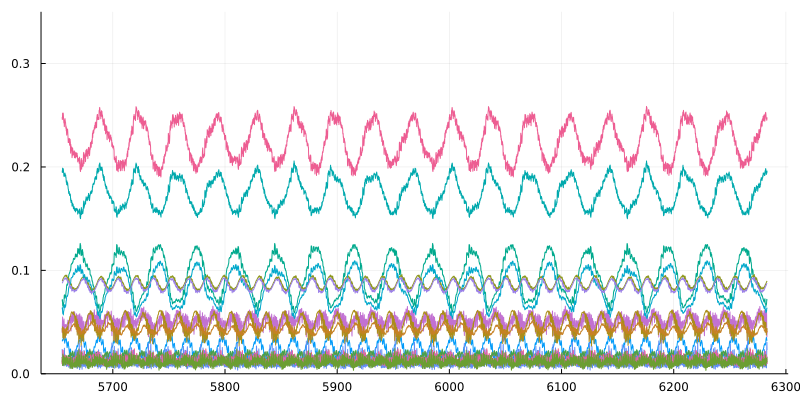

In [154]:
plot_us = sol.u[idxs_to_plot]
plot_ts = sol.t[idxs_to_plot]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(0, 0.35))
for i in 2:16
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!(legend=nothing)

In [158]:
vs = collect(0.0:20.0:100.0)
forces = zeros(length(vs))
exc_pop = zeros(length(vs))

t_end = 2π * 1000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 50000)

@time begin
    Threads.@threads for i in 1:length(vs)
        
        v = vs[i]
        
        previous_force = 0.0
        force = 1.0
        error = 1.0
        
        p_ = deepcopy(p)
        
        p_.particle.r0 = SVector(0, 0, 0) / (1 / (2π / λ))
        p_.particle.v = SVector(0.0, 0.0, v)
        p_.particle.v = round_vel(p_.particle.v, λ, Γ, freq_res) / (Γ / (2π / λ))
        
        vs[i] = sqrt(sum(p_.particle.v.^2))
        
        ρ0 = zeros(ComplexF64,(16,16))
        ρ0[1,1] = 1.0

        prob = ODEProblem(ρ!, ρ0, tspan, p_)
        sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-6, saveat=times)

        offset = 0
        period_idx = find_idx_for_time(period, sol.t, true)
        force_idxs = (period_idx - offset):(length(times) - offset)
        
        previous_force = force
        force = calculate_force_from_period(p_, sol, force_idxs)

        forces[i] = force
        exc_pop[i] = real(sum(diag(mean(sol.u[force_idxs]))[13:end]))
            
    end
end

  6.723930 seconds (457.50 k allocations: 1.321 GiB, 0.89% compilation time)


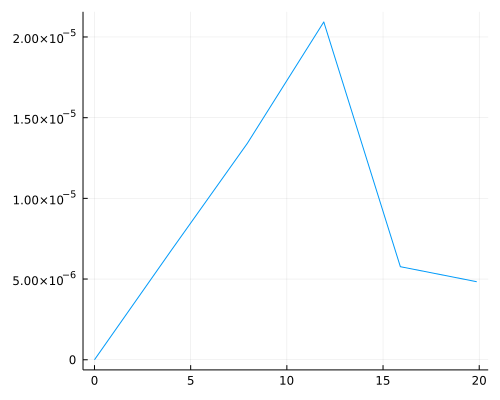

In [159]:
plot(vs, forces, size=(500,400), legend=nothing)

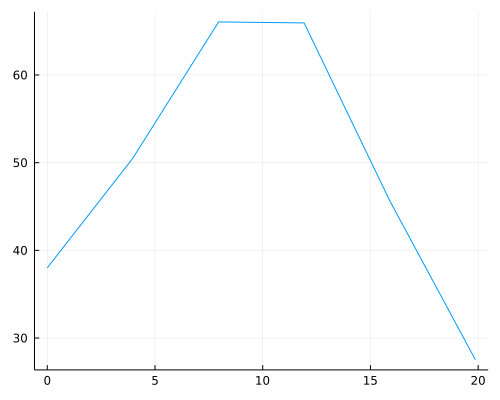

In [160]:
plot(vs, 10^3 * exc_pop, size=(500,400), legend=nothing)